In [1]:
import time
import astroquery.heasarc
from astropy.coordinates import SkyCoord
import astropy.units as u

from astroquery.jplhorizons import Horizons
import numpy as np
import pandas as pd

from collections import defaultdict

from astropy.time import Time

import getpass
import oda_api.token

import logging

from oda_api.api import DispatcherAPI

from oda_api.plot_tools import OdaImage

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.patches import Circle

In the first cell, we define our query function. This is to be copied and pasted each time we want to query science windows. 

In [ ]:
Heasarc = astroquery.heasarc.Heasarc()

def get_scw_list(ra_obj, dec_obj,radius,start_date,end_date ):
    
    R = Heasarc.query_region(
            position = SkyCoord(ra_obj, dec_obj, unit='deg'),
            radius = f"{radius} deg",
            catalog = 'intscw',
            good_isgri = ">1000",
        )
    R.sort('scw_id') 
    # R['scw_id', 'scw_ver', 'start_date', 'end_date', 'ra', 'dec'].pprint()
    return R['scw_id'], R['scw_ver'], R['start_date'], R['end_date'] 


assert astroquery.__version__ >= '0.4.2.dev6611'
assert 'isdc' in astroquery.heasarc.Conf.server.cfgtype

# columns = Heasarc.list_columns(catalog_name='intscw')
# columns.sort('name')
# columns[:].pprint(align='<')

      name      ...  unit 
--------------- ... ------
data_in_heasarc ...       
data_size       ... byte  
dec             ... degree
end_date        ... mjd   
good_isgri      ... s     
good_jemx1      ... s     
good_jemx2      ... s     
good_omc        ... s     
good_picsit     ... s     
good_spi        ... s     
obs_id          ...       
obs_type        ...       
pi_name         ...       
ra              ... degree
scw_id          ...       
scw_type        ...       
scw_ver         ...       
start_date      ... mjd   
status          ...       


In this second cell, define our source or region to query.
What we want to do for Jupiter is find Jupiter's time-dependent position and query that for a given search radius and time interval. We use astroquery's JPL Horizons module.

In [ ]:
epochs = {'start':'2003-01-01', 'stop':'2004-01-01', 'step':'30d'}

jupiter = Horizons(id='599', location='@0',epochs=epochs) 
eph = jupiter.ephemerides()
#print(eph)

ra_values = eph['RA']  # in degrees
dec_values = eph['DEC']  # in degrees
print(eph[['datetime_str', 'RA', 'DEC']])

# let's calculate the mean change in Jupiter's position in the sky per day
coords = SkyCoord(ra=np.array(ra_values) * u.deg, dec=np.array(dec_values) * u.deg, frame='icrs')
angular_separations = coords[:-1].separation(coords[1:])
mean_change = np.mean(angular_separations) # .to(u.arcmin)
# print(f"Mean change in Jupiter's position per week: {mean_change:.3f}")


   datetime_str       RA      DEC   
       ---           deg      deg   
----------------- --------- --------
2003-Jan-01 00:00 133.13461 18.23402
2003-Jan-31 00:00 135.56302 17.61365
2003-Mar-02 00:00 137.96556 16.96624
2003-Apr-01 00:00 140.34267  16.2934
2003-May-01 00:00 142.69497 15.59668
2003-May-31 00:00 145.02316 14.87762
2003-Jun-30 00:00 147.32805 14.13772
2003-Jul-30 00:00 149.61054 13.37845
2003-Aug-29 00:00 151.87158 12.60126
2003-Sep-28 00:00 154.11218 11.80757
2003-Oct-28 00:00 156.33344 10.99874
2003-Nov-27 00:00 158.53652 10.17611
2003-Dec-27 00:00 160.72261  9.34097


Error due to seperation between INTEGRAL and Earth.

In [4]:
D = 150e3 # max distance between INTEGRAL and Earth (~ 150 000 km)
r = 4 * 149597870.7 # min distance between Jupiter and Earth is ~ 4 AU 

error = D/r * 206265/60 # convert to arcmin
print("Angular error is ", error, " arcmin") # below 1', insignificant (FWHM is 12' for INTEGRAL)

Angular error is  0.8617477267341882  arcmin


Retrieve the science windows. Make sure to choose ones that are of pointing type (id ends with 0).

In [11]:
scw_ids = []
scw_versions = []
scw_start_times = []
scw_end_times = []

# Loop through the ephemeris
for row in eph:
    ra = float(row['RA'])
    dec = float(row['DEC'])
    radius = 8.
    scw_id, scw_ver, scw_start, scw_end = get_scw_list(ra, dec, radius, '2004-01-01T00:00:00', '2005-01-01T00:00:00')
    scw_ids.extend(scw_id)
    scw_versions.extend(scw_ver)
    scw_start_times.extend(scw_start)
    scw_end_times.extend(scw_end)

# filter by type
scw_ids = [scw_id for scw_id in scw_ids if int(scw_id) % 10 == 0]
scw_versions = [scw_versions[i] for i in range(len(scw_ids)) if int(scw_ids[i]) % 10 == 0]
scw_start_times = [scw_start_times[i] for i in range(len(scw_ids)) if int(scw_ids[i]) % 10 == 0]
scw_end_times = [scw_end_times[i] for i in range(len(scw_ids)) if int(scw_ids[i]) % 10 == 0]

print("Found ", len(scw_ids), " pointing science windows")

   scw_id    scw_ver    start_date        end_date         ra      dec   
                            d                d            deg      deg   
------------ ------- ---------------- ---------------- --------- --------
012001160010     001 52922.1211843599 52922.1280477894 133.28282 21.02836
012001160021     001 52922.1280477894 52922.1293903827 133.37520 21.27417
012001170010     001 52922.1293903827 52922.1396450178 133.57558 21.79975
012001170021     001 52922.1396450178  52922.140686685 133.57478 21.80017
012001180010     001  52922.140686685 52922.1492399302 133.57362 21.79961
012001180021     001 52922.1492399302  52922.153256136 139.65305 19.85491
012101180021     001  52925.136567894 52925.1449243798 135.20492 23.69340
012301060010     001 52930.8118718199 52930.8187236753 134.57841 15.25308
012301060021     001 52930.8187236753 52930.8200546946 134.65942 15.50202
012301070010     001 52930.8200546946 52930.8303093296 134.81267 15.97019
         ...     ...              ... 

We then pick any science window(s) we want. We could first group the ScWs by revolutions and pointings. This allows us to, for example, average/stack the images over pointings or over ScWs for a given pointing. This could be useful for mid-term timescale variability. 

In [ ]:
grouped_scws = defaultdict(lambda: defaultdict(list))

scw_ids = list(set(scw_ids))

# Group by Revolution (RRRR) and then by Pointing (PPPP)
for scw in scw_ids:
    scw_str = str(scw)
    revolution = scw_str[:4]  # Extract RRRR
    pointing = scw_str[4:8]   # Extract PPPP
    grouped_scws[revolution][pointing].append(scw)

grouped_scws = sorted(grouped_scws.items(), key=lambda x: (x[0], sorted(x[1].keys()))) # sort

print(grouped_scws)
for rev, pointings in list(grouped_scws):
    print(f"Revolution: {rev}")
    for pointing, scws in pointings.items():
        print(f"  Pointing: {pointing}, # of ScWs: {len(scws)}")

Similarly, we can order the ScWs by observation times. 

In [ ]:
start_times_dt = [Time(mjd, format='mjd').datetime for mjd in scw_start_times]

scw_data = list(zip(scw_ids, scw_versions, scw_start_times, scw_end_times, start_times_dt))

scw_data_sorted = sorted(scw_data, key=lambda x: x[4])

scw_ids_sorted = [x[0] for x in scw_data_sorted]
scw_versions_sorted = [x[1] for x in scw_data_sorted]
scw_start_times_sorted = [x[2] for x in scw_data_sorted]
scw_end_times_sorted = [x[3] for x in scw_data_sorted]

print("Sorted Science Windows by Start Time:")
print(scw_ids_sorted)
print(min(scw_start_times), max(scw_start_times))


Now pick a specific ScW.

In [170]:
scw_pick =  [(s+"."+v).strip() for s,v in zip(scw_ids_sorted,scw_versions_sorted)]

i = 0 # requested index (0 is earliest, -1 is latest)

scw_pick = scw_pick[i]
print(scw_pick)
print(f"Start: {Time(scw_start_times_sorted[i], format='mjd').datetime}, end: {Time(scw_end_times_sorted[i], format='mjd').datetime}, duration:{Time(scw_end_times_sorted[i], format='mjd').datetime-Time(scw_start_times_sorted[i], format='mjd').datetime}")

236700180010.001
Start: 2003-05-29 12:28:09.232338, end: 2003-05-29 13:08:56.233550, duration:0:40:47.001212


Before moving on to using this query for our ODA, we need to input our token (use local file so don't need to input it every time). Need to update it regularly however.

In [ ]:
# token = ''
# token = getpass.getpass('Insert the token')
token = oda_api.token.discover_token() # get token stored locally

We also add logging to help visualize the process.

In [16]:
logging.getLogger().setLevel(logging.INFO) # WARNING, INFO or DEBUG
logging.getLogger('oda_api').addHandler(logging.StreamHandler())

Now let us look at an example.

In [8]:
disp = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock")

par_dict = {
"E1_keV": "15",
"E2_keV": "30",
"T_format": "isot",
"detection_threshold": "5",
"instrument": "isgri",
"osa_version": "OSA10.2",
"product": "isgri_image",
"product_type": "Real",
"scw_list": ["027300510010.001"],
'token': token
}
# "integral_data_rights": "all-private" had to be removed as didn't have the rights

data_collection = disp.get_product(**par_dict)
data_collection.show()
data_collection.mosaic_image_0_mosaic.show()

print(data_collection.mosaic_image_0_mosaic.show_meta())


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


ID=0 prod_name=mosaic_image_0_mosaic  meta_data: {'product': 'mosaic', 'instrument': 'isgri', 'src_name': '', 'query_parameters': None}

ID=1 prod_name=dispatcher_catalog_1  meta_data: 

------------------------------
name: mosaic_image
meta_data dict_keys(['product', 'instrument', 'src_name', 'query_parameters'])
number of data units 6
------------------------------
data uniti 0 ,name: PRIMARY
data uniti 1 ,name: GROUPING
data uniti 2 ,name: ISGR-MOSA-IMA
data uniti 3 ,name: ISGR-MOSA-IMA
data uniti 4 ,name: ISGR-MOSA-IMA
data uniti 5 ,name: ISGR-MOSA-IMA
------------------------------
product : mosaic
instrument : isgri
src_name : 
query_parameters : None
------------------------------
None


Finally, let us image our results.

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53378.351875 from DATE-OBS.
Set MJD-END to 53378.376331 from DATE-END'. [astropy.wcs.wcs]
/home/hthums/micromamba/envs/jupiter_xray/lib/python3.9/site-packages/oda_api/plot_tools.py:101: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


'./027300510010.001mosaic.fits'

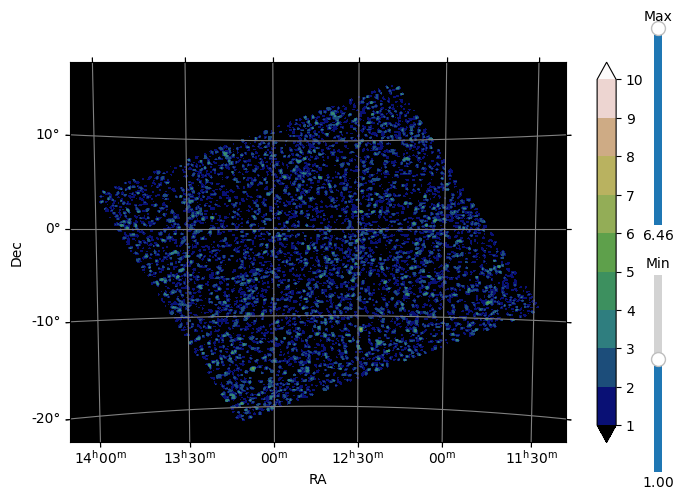

In [9]:
im=OdaImage(data_collection)
_ = im.show()
im.write_fits('027300510010.001')

In [11]:
# Details on the ScW
start_time = Time("2005-01-08T08:26:42.6", format='isot').datetime
end_time = Time("2005-01-08T09:01:55.6", format='isot').datetime
duration = end_time - start_time

print(f"Start: {start_time}, End: {end_time}, Duration: {duration}")

Start: 2005-01-08 08:26:42.600000, End: 2005-01-08 09:01:55.600000, Duration: 0:35:13


In [14]:
epochs = {'start':"2005-01-08T08:26:42.6", 'stop':"2005-01-08T09:01:55.6", 'step':'10m'}
jupiter = Horizons(id='599', location='@0',epochs=epochs)
eph = jupiter.ephemerides()
ra_values = eph['RA']  
dec_values = eph['DEC']  
print(eph[['datetime_str', 'RA', 'DEC']])

      datetime_str           RA      DEC   
          ---               deg      deg   
------------------------ --------- --------
2005-Jan-08 08:26:42.600 187.36929 -1.76614
2005-Jan-08 08:36:42.600 187.36977 -1.76634
2005-Jan-08 08:46:42.600 187.37025 -1.76655
2005-Jan-08 08:56:42.600 187.37073 -1.76676


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53378.351875 from DATE-OBS.
Set MJD-END to 53378.376331 from DATE-END'. [astropy.wcs.wcs]
/tmp/ipykernel_1067/155082043.py:18: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower')
/tmp/ipykernel_1067/155082043.py:18: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower')
/tmp/ipykernel_1067/155082043.py:23: RuntimeWarning: cdelt will be ignored since cd is present
  pixel_scale = np.abs(wcs.wcs.cdelt[0]) * 3600  # pixel size in arcseconds


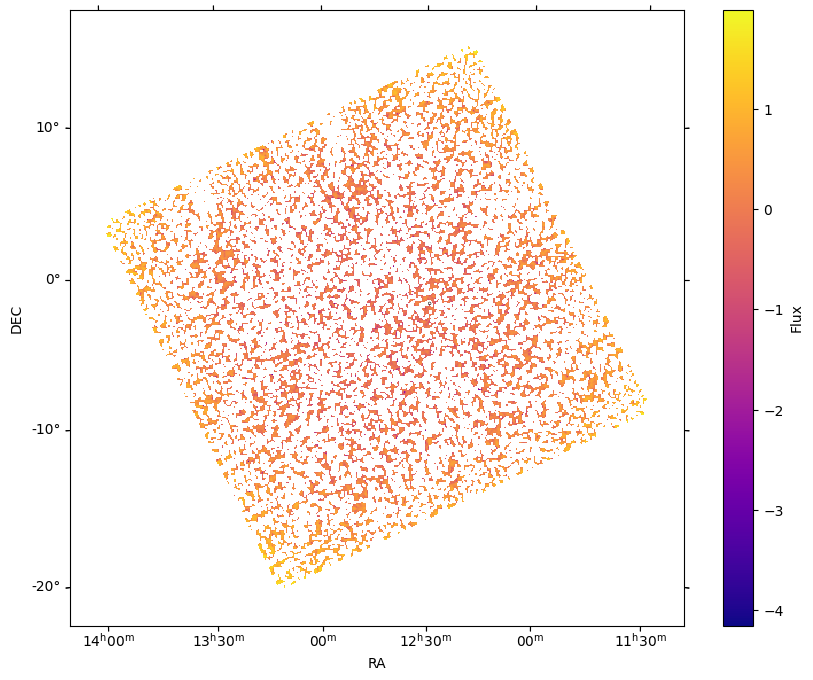

In [23]:
from astropy.wcs import WCS
from matplotlib.patches import Circle

fits_file = "027300510010.001mosaic.fits"

# Jupiter
ra_deg = ra_values[0]
dec_deg = dec_values[0]

with fits.open(fits_file) as hdul:
    image_data = hdul[2].data 
    wcs = WCS(hdul[2].header)  

x, y = wcs.all_world2pix(ra_deg, dec_deg, 1)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower')

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

pixel_scale = np.abs(wcs.wcs.cdelt[0]) * 3600  # pixel size in arcseconds
circle_radius_pixels = 30 * 50 / pixel_scale / 2  # radius in pixels

circle = Circle((x, y), circle_radius_pixels, edgecolor='black', facecolor='none', lw=2)
ax.add_patch(circle)

plt.colorbar(im, label="Flux")
plt.show()
